# Exploring options for accounting for change in CAFE60 bias correction scheme in 1992

In [14]:
import xesmf

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

# Cluster

In [6]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "04:00:00"
cores = 24
memory = "96GB"
cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
    header_skip=["select"],
)

In [7]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.56.71:8787/status,
Dashboard: http://10.6.56.71:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.56.71:46677,Workers: 0
Dashboard: http://10.6.56.71:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [16]:
def estimate_cell_areas(ds, lon_dim="lon", lat_dim="lat"):
    """
    Calculate the area of each grid cell.
    Stolen/adapted from: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    """

    from numpy import deg2rad, cos, tan, arctan

    def _earth_radius(lat):
        """Calculate radius of Earth assuming oblate spheroid defined by WGS84"""

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b ** 2 / a ** 2)

        # convert from geodecic to geocentric
        # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = arctan((1 - e2) * tan(lat))

        # radius equation
        # see equation 3-107 in WGS84
        return (a * (1 - e2) ** 0.5) / (1 - (e2 * cos(lat_gc) ** 2)) ** 0.5

    R = _earth_radius(ds[lat_dim])

    dlat = deg2rad(ds[lat_dim].diff(lat_dim))
    dlon = deg2rad(ds[lon_dim].diff(lon_dim))

    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ds[lat_dim]))

    return dy * dx

# Interpolate sst to HadISST grid

In [166]:
data_dir = "/g/data/xv83/dcfp/CAFE60v1/"
realm = "ocean_month.zarr.zip"
variable = "sst"

cafe_60_raw = xr.open_dataset(f"{data_dir}{realm}", engine="zarr", chunks={})[variable]

cafe_grid = xr.open_dataset(
    "/g/data/xv83/users/ds0092/data/CAFE/grid_info/cafe_ocean_grid_info.nc"
)
cafe_60_raw = cafe_60_raw.assign_coords(
    {"geolon_t": cafe_grid["geolon_t"], "geolat_t": cafe_grid["geolat_t"]}
)

In [167]:
had = xr.open_dataset(
    "/g/data/xv83/reanalyses/HadISST/ocean_month.zarr", engine="zarr", chunks={}
)
had = had.where(had > -1000)["sst"]
had = had.rename({"longitude": "lon", "latitude": "lat"})
had = had.sortby("lat")
had_area = estimate_cell_areas(had).broadcast_like(had, exclude=["time"]).fillna(0)
had = had.assign_coords({"area": had_area}).compute()

In [168]:
ds_in = cafe_60_raw.rename(
    {"xt_ocean": "x", "yt_ocean": "y", "geolon_t": "lon", "geolat_t": "lat"}
)
ds_out = had_area

regridder = xesmf.Regridder(ds_in, ds_out, "bilinear")
cafe_60 = regridder(ds_in).mean("ensemble")
cafe_60 = cafe_60.assign_coords({"area": had_area}).compute()

/g/data/xv83/users/ds0092/software/miniconda3/envs/xesmf/lib/python3.9/site-packages/dask/array/core.py:405: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/xv83/users/ds0092/software/miniconda3/envs/xesmf/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


# Can we just subtract the bias pre 1992?

In [169]:
transition_year = 1992

p1 = slice("1964", str(transition_year - 1))  # 28 years
p2 = slice(str(transition_year), "2019")  # 28 years

cafe_60_p1_clim = cafe_60.sel(time=p1).groupby("time.month").mean("time")
cafe_60_p2_clim = cafe_60.sel(time=p2).groupby("time.month").mean("time")

had_p1_clim = had.sel(time=p1).groupby("time.month").mean("time")
had_p2_clim = had.sel(time=p2).groupby("time.month").mean("time")

cafe_60_pre1992_bias = had_p1_clim - cafe_60_p1_clim
cafe_60_post1992_bias = had_p2_clim - cafe_60_p2_clim

In [178]:
cafe_60_p1_bc0 = (
    cafe_60.sel(time=slice(None, str(transition_year - 1))).groupby("time.month")
    + cafe_60_pre1992_bias
)
cafe_60_p2_bc0 = (
    cafe_60.sel(time=slice(str(transition_year), None)).groupby("time.month")
    + cafe_60_post1992_bias
)
cafe_60_bc0 = xr.concat(
    [cafe_60_p1_bc0.drop("month"), cafe_60_p2_bc0.drop("month")],
    dim="time",
)

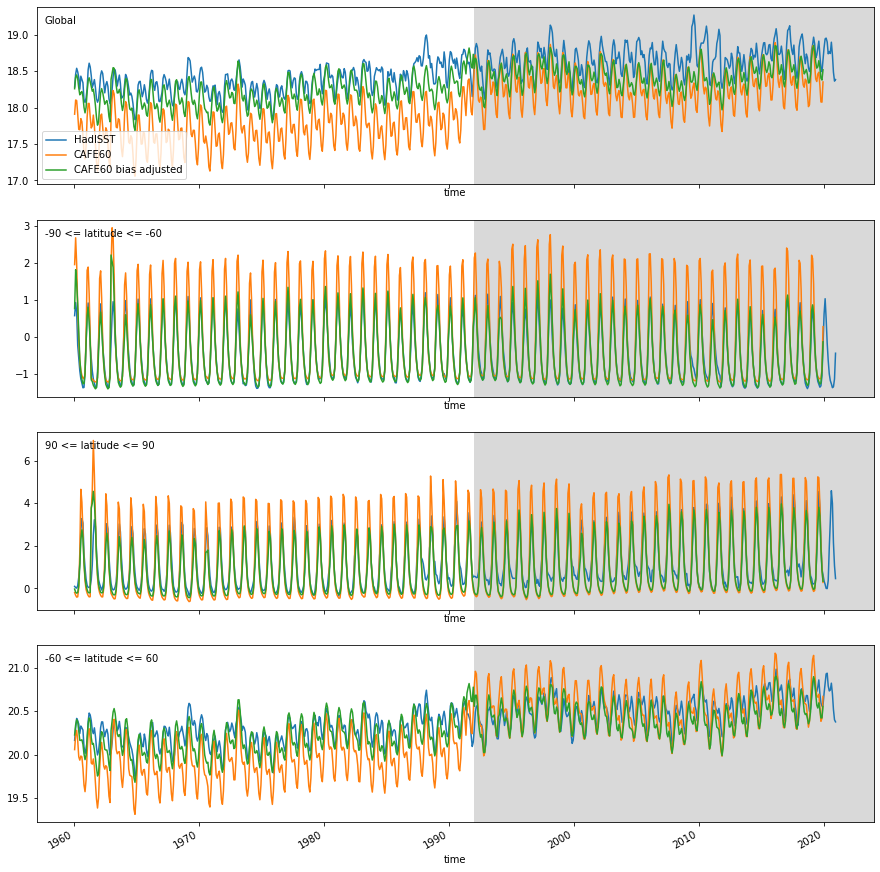

In [185]:
fig = plt.figure(figsize=(15, 15))
axs = fig.subplots(4, 1, sharex=True)

had_ = had.sel(time=slice("1960", "2020"))


def as_datetime64(ds, time_var="time", fmt="%Y-%m-%dT%H:%M:%S"):
    if isinstance(time_var, str):
        time_var = [time_var]
    _convert = np.vectorize(lambda t: np.datetime64(t.strftime(fmt)))
    for var in time_var:
        if var in ds.dims:
            ds = ds.assign_coords({var: _convert(ds[var].values)})
        else:
            ds[var].values = _convert(ds[var].values)
    return ds


def area_mean(ds):
    return ds.weighted(ds["area"]).mean(["lat", "lon"])


def shading(ax):
    trans = np.datetime64("1992-01-01")
    end = np.datetime64("2030-01-01")
    ax.fill_between(
        [trans, end], [ylim[1], ylim[1]], [ylim[0], ylim[0]], color=[0.85, 0.85, 0.85]
    )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


def add_text(text, ax):
    ax.text(
        0.01,
        0.95,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )


# Global -----
ax = 0
area_mean(had_).plot(ax=axs[ax], label="HadISST")
as_datetime64(area_mean(cafe_60)).plot(ax=axs[ax], label="CAFE60")
as_datetime64(area_mean(cafe_60_bc0)).plot(ax=axs[ax], label="CAFE60 bias adjusted")
xlim = axs[ax].get_xlim()
ylim = axs[ax].get_ylim()
shading(axs[ax])
axs[ax].legend(loc="lower left")
add_text("Global", axs[ax])

# SH -----
ax = 1
sl = {"lat": slice(-90, -60)}
area_mean(had_.sel(sl)).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60.sel(sl))).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60_bc0.sel(sl))).plot(ax=axs[ax])
ylim = axs[ax].get_ylim()
shading(axs[ax])
add_text("-90 <= latitude <= -60", axs[ax])

# NH -----
ax = 2
sl = {"lat": slice(60, 90)}
area_mean(had_.sel(sl)).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60.sel(sl))).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60_bc0.sel(sl))).plot(ax=axs[ax])
ylim = axs[ax].get_ylim()
shading(axs[ax])
add_text("90 <= latitude <= 90", axs[ax])

# Tropics -----
ax = 3
sl = {"lat": slice(-60, 60)}
area_mean(had_.sel(sl)).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60.sel(sl))).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60_bc0.sel(sl))).plot(ax=axs[ax])
ylim = axs[ax].get_ylim()
shading(axs[ax])
add_text("-60 <= latitude <= 60", axs[ax])

# Looks okay... How does this work for other variables?

In [253]:
data_dir = "/g/data/xv83/dcfp/CAFE60v1/"
realm = "atmos_isobaric_month.zarr.zip"
variable = "precip"

cafe_60 = (
    xr.open_dataset(f"{data_dir}{realm}", engine="zarr", chunks={})[variable] * 86400
)

cafe_60_area = (
    estimate_cell_areas(cafe_60)
    .broadcast_like(cafe_60, exclude=["time", "ensemble"])
    .fillna(0)
)
cafe_60 = cafe_60.assign_coords({"area": cafe_60_area})
cafe_60 = cafe_60.mean("ensemble").compute()

In [254]:
jra55 = xr.open_zarr(
    "/g/data/xv83/reanalyses/JRA55/surface_month_cafe-grid.zarr.zip",
    use_cftime=True,
)["TPRAT_GDS0_SFC"]

jra55 = jra55.rename({"initial_time0_hours": "time"})
# Force to Julian calendar
jra55 = jra55.assign_coords(
    {
        "time": xr.cftime_range(
            start=jra55.time[0].item().strftime(),
            end=jra55.time[-1].item().strftime(),
            freq="MS",
            calendar="julian",
        )
    }
)
jra55 = jra55.assign_coords({"area": cafe_60_area}).compute()

In [255]:
transition_year = 1992

p1 = slice("1964", str(transition_year - 1))  # 28 years
p2 = slice(str(transition_year), "2019")  # 28 years

cafe_60_p1_clim = cafe_60.sel(time=p1).groupby("time.month").mean("time")
cafe_60_p2_clim = cafe_60.sel(time=p2).groupby("time.month").mean("time")

jra55_p1_clim = jra55.sel(time=p1).groupby("time.month").mean("time")
jra55_p2_clim = jra55.sel(time=p2).groupby("time.month").mean("time")

cafe_60_pre1992_bias = jra55_p1_clim - cafe_60_p1_clim
cafe_60_post1992_bias = jra55_p2_clim - cafe_60_p2_clim

In [256]:
cafe_60_p1_bc0 = (
    cafe_60.sel(time=slice(None, str(transition_year - 1))).groupby("time.month")
    + cafe_60_pre1992_bias
)
cafe_60_p2_bc0 = (
    cafe_60.sel(time=slice(str(transition_year), None)).groupby("time.month")
    + cafe_60_post1992_bias
)
cafe_60_bc0 = xr.concat(
    [cafe_60_p1_bc0.drop("month"), cafe_60_p2_bc0.drop("month")],
    dim="time",
)

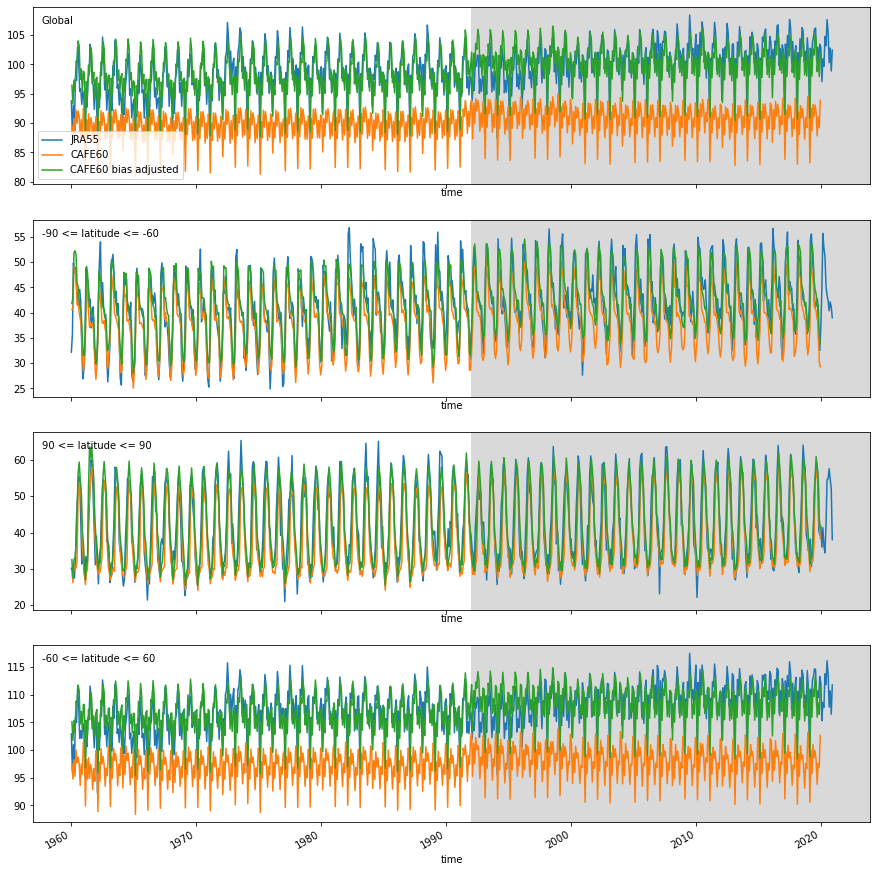

In [257]:
fig = plt.figure(figsize=(15, 15))
axs = fig.subplots(4, 1, sharex=True)

jra55_ = jra55.sel(time=slice("1960", "2020"))


def as_datetime64(ds, time_var="time", fmt="%Y-%m-%dT%H:%M:%S"):
    if isinstance(time_var, str):
        time_var = [time_var]
    _convert = np.vectorize(lambda t: np.datetime64(t.strftime(fmt)))
    for var in time_var:
        if var in ds.dims:
            ds = ds.assign_coords({var: _convert(ds[var].values)})
        else:
            ds[var].values = _convert(ds[var].values)
    return ds


def area_mean(ds):
    return ds.weighted(ds["area"]).mean(["lat", "lon"])


def shading(ax):
    trans = np.datetime64("1992-01-01")
    end = np.datetime64("2030-01-01")
    ax.fill_between(
        [trans, end], [ylim[1], ylim[1]], [ylim[0], ylim[0]], color=[0.85, 0.85, 0.85]
    )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


def add_text(text, ax):
    ax.text(
        0.01,
        0.95,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
    )


# Global -----
ax = 0
as_datetime64(area_mean(jra55_)).plot(ax=axs[ax], label="JRA55")
as_datetime64(area_mean(cafe_60)).plot(ax=axs[ax], label="CAFE60")
as_datetime64(area_mean(cafe_60_bc0)).plot(ax=axs[ax], label="CAFE60 bias adjusted")
xlim = axs[ax].get_xlim()
ylim = axs[ax].get_ylim()
shading(axs[ax])
axs[ax].legend(loc="lower left")
add_text("Global", axs[ax])

# SH -----
ax = 1
sl = {"lat": slice(-90, -60)}
as_datetime64(area_mean(jra55_.sel(sl))).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60.sel(sl))).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60_bc0.sel(sl))).plot(ax=axs[ax])
ylim = axs[ax].get_ylim()
shading(axs[ax])
add_text("-90 <= latitude <= -60", axs[ax])

# NH -----
ax = 2
sl = {"lat": slice(60, 90)}
as_datetime64(area_mean(jra55_.sel(sl))).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60.sel(sl))).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60_bc0.sel(sl))).plot(ax=axs[ax])
ylim = axs[ax].get_ylim()
shading(axs[ax])
add_text("90 <= latitude <= 90", axs[ax])

# Tropics -----
ax = 3
sl = {"lat": slice(-60, 60)}
as_datetime64(area_mean(jra55_.sel(sl))).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60.sel(sl))).plot(ax=axs[ax])
as_datetime64(area_mean(cafe_60_bc0.sel(sl))).plot(ax=axs[ax])
ylim = axs[ax].get_ylim()
shading(axs[ax])
add_text("-60 <= latitude <= 60", axs[ax])

In [259]:
2020 - 1992

28